In [7]:
import torch
import math
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms

# Holographic Light Transport Assignment

## Instructions

### 1. Download the Sample Hologram
Download the sample hologram image from the following link:
[Sample Hologram](https://github.com/kaanaksit/odak/blob/master/test/data/sample_hologram.png)

### 2. Image Parameters
- **Resolution**: (2400, 4094)
- **Wavelengths**: [639e-9, 515e-9, 473e-9] (in meters)
- **Pixel Pitch**: 3.74e-6 (in meters)
- **Distances**: [2.5e-3, 0, 2.5e-3] (in meters)

### 3. Phase-only Hologram
- **Amplitude**: 1
- **Phase**: `sample_hologram`

### 4. Create a Complex Field
Create a complex field where:
- **Amplitude**: 1
- **Phase**: provided by the `sample_hologram`

### 5. Phase Normalization
Normalize the phase of the complex field:
- **Range**: 0 - 255 (image pixel values)
- **Convert to radians**: `phase = sample_hologram / 255 * 2 * pi`

### 6. Define the Source Plane
```python
source_plane = complex_field(amplitude, phase)


In [8]:
def amplitude_tensor(image_path):
    image_shape = Image.open(image_path).size
    # generate 2-D amplitude tensor same size as the phase tensor all values are 1.0
    amplitude_tensor = torch.ones(image_shape)
    return amplitude_tensor.T
amplitudeTensor = amplitude_tensor("sample_hologram.png")
print(amplitudeTensor)
amplitudeTensor.shape

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])


torch.Size([2400, 4094])

In [9]:
def phase_image2phase_tensor(image_path):
    image_grey = Image.open(image_path).convert("L") # convert the image to gray scale
    transform = transforms.ToTensor()
    image_tensor = transform(image_grey)
    image_tensor = image_tensor.squeeze(0) # delete a dimension from the tensor
    image_tensor_normalized = image_tensor * 2 * math.pi
    return image_tensor_normalized # return the tensor between 0 and 2*pi
    
phaseTensor = phase_image2phase_tensor("sample_hologram.png")
print(phaseTensor)
print(phaseTensor.max())
phaseTensor.shape

tensor([[5.2237, 0.8624, 5.1497,  ..., 0.7885, 5.3469, 0.6653],
        [1.0349, 4.9280, 1.1581,  ..., 5.1251, 1.1334, 5.2729],
        [5.1497, 1.0842, 5.1251,  ..., 0.9610, 5.2729, 0.8870],
        ...,
        [1.3059, 4.9526, 1.3552,  ..., 4.9033, 1.3552, 5.0019],
        [4.9773, 1.3552, 4.9280,  ..., 1.4045, 4.9033, 1.3059],
        [1.2074, 5.0019, 1.3552,  ..., 4.9280, 1.3306, 5.0512]])
tensor(6.2585)


torch.Size([2400, 4094])

In [10]:
def source_plain(amplitude_tensor, phase_tensor):
    # generate a plain wave source
    source = amplitude_tensor * torch.exp(1j * phase_tensor)
    return source

In [13]:
def band_limited_angular_spectrum(
    amplitude=amplitudeTensor,
    phase=phaseTensor,
    z=0.0,
    wave_length=0.0,
    pixel_pitch=3.74e-6,
):
    if not isinstance(amplitude, torch.Tensor) or not isinstance(phase, torch.Tensor):
        raise ValueError("Amplitude tensor or phase tensor is required")
    if amplitude.shape != phase.shape:
        raise ValueError("Amplitude and phase tensors must have the same shape")

    dx = pixel_pitch  # the sampling interval
    sample_u = amplitude.shape[0]
    sample_v = amplitude.shape[1]
    S_x = sample_u * dx  # the x-size of the hologram plain
    S_y = sample_v * dx  # the y-size of the hologram plain

    # generate the 2-D frequency mesh
    freq_x = torch.fft.fftfreq(sample_u, dx)
    freq_y = torch.fft.fftfreq(sample_v, dx)

    freq_x_unsqueezed = torch.unsqueeze(freq_x, dim=1).expand(
        -1, len(freq_y)
    )  # expand to len(y) columns
    freq_y_unsqueezed = torch.unsqueeze(freq_y, dim=0).expand(
        len(freq_x), -1
    )  # expand to len(x) rows

    freq_square = freq_x_unsqueezed**2 + freq_y_unsqueezed**2

    freq_squre_max = torch.full((sample_u, sample_v), 1 / wave_length) ** 2
    w_square_0 = freq_squre_max - freq_square
    mask = w_square_0 > 0
    w_square = torch.where(mask, w_square_0, 0)

    # transfer function
    H_FR = torch.empty((sample_u, sample_v), dtype=torch.complex64)
    H_FR = torch.exp(2j * math.pi * z * torch.sqrt(w_square))

    # clipper the frequency
    d_u = 1 / S_x  # S_x instead of 2 * S_x
    d_v = 1 / S_y  # S_y instead of 2 * S_y
    u_limit = 1 / (math.sqrt((2 * d_u * z) ** 2 + 1) * wave_length)
    v_limit = 1 / (math.sqrt((2 * d_v * z) ** 2 + 1) * wave_length)
    mask_u = torch.abs(freq_x) < u_limit
    mask_v = torch.abs(freq_y) < v_limit
    mask = mask_u.unsqueeze(1) & mask_v.unsqueeze(0)
    H_FR = H_FR * mask

    sourcePlain = source_plain(amplitude, phase)
    G_0 = torch.fft.ifftshift(sourcePlain)

    G_z = G_0 * H_FR

    phase_z = torch.fft.ifftshift(torch.angle(G_z))
    amplitude_z = torch.fft.ifftshift(torch.abs(G_z))

    g_z = torch.fft.ifft2(G_z)
    if mask.sum() == 2400*4094:
        print("The clipper is not working.")
    else:
        print("The clipper is working.\n"
              "The maximum frequency is clipped to u = {} and v = {}.".format(u_limit, v_limit))
    return g_z, amplitude_z, phase_z

In [14]:
g_z_red, amplitude_z_red, phase_z_red = band_limited_angular_spectrum(amplitudeTensor, phaseTensor, z=2.5e-3, wave_length=639e-9, pixel_pitch=3.74e-6)
g_z_green, amplitude_z_green, phase_z_green = band_limited_angular_spectrum(amplitudeTensor, phaseTensor, z=0.0, wave_length=515e-9, pixel_pitch=3.74e-6)
g_z_blue, amplitude_z_blue, phase_z_blue = band_limited_angular_spectrum(amplitudeTensor, phaseTensor, z=2.5e-3, wave_length=417e-9, pixel_pitch=3.74e-6)

The clipper is not working.
The clipper is not working.
The clipper is not working.


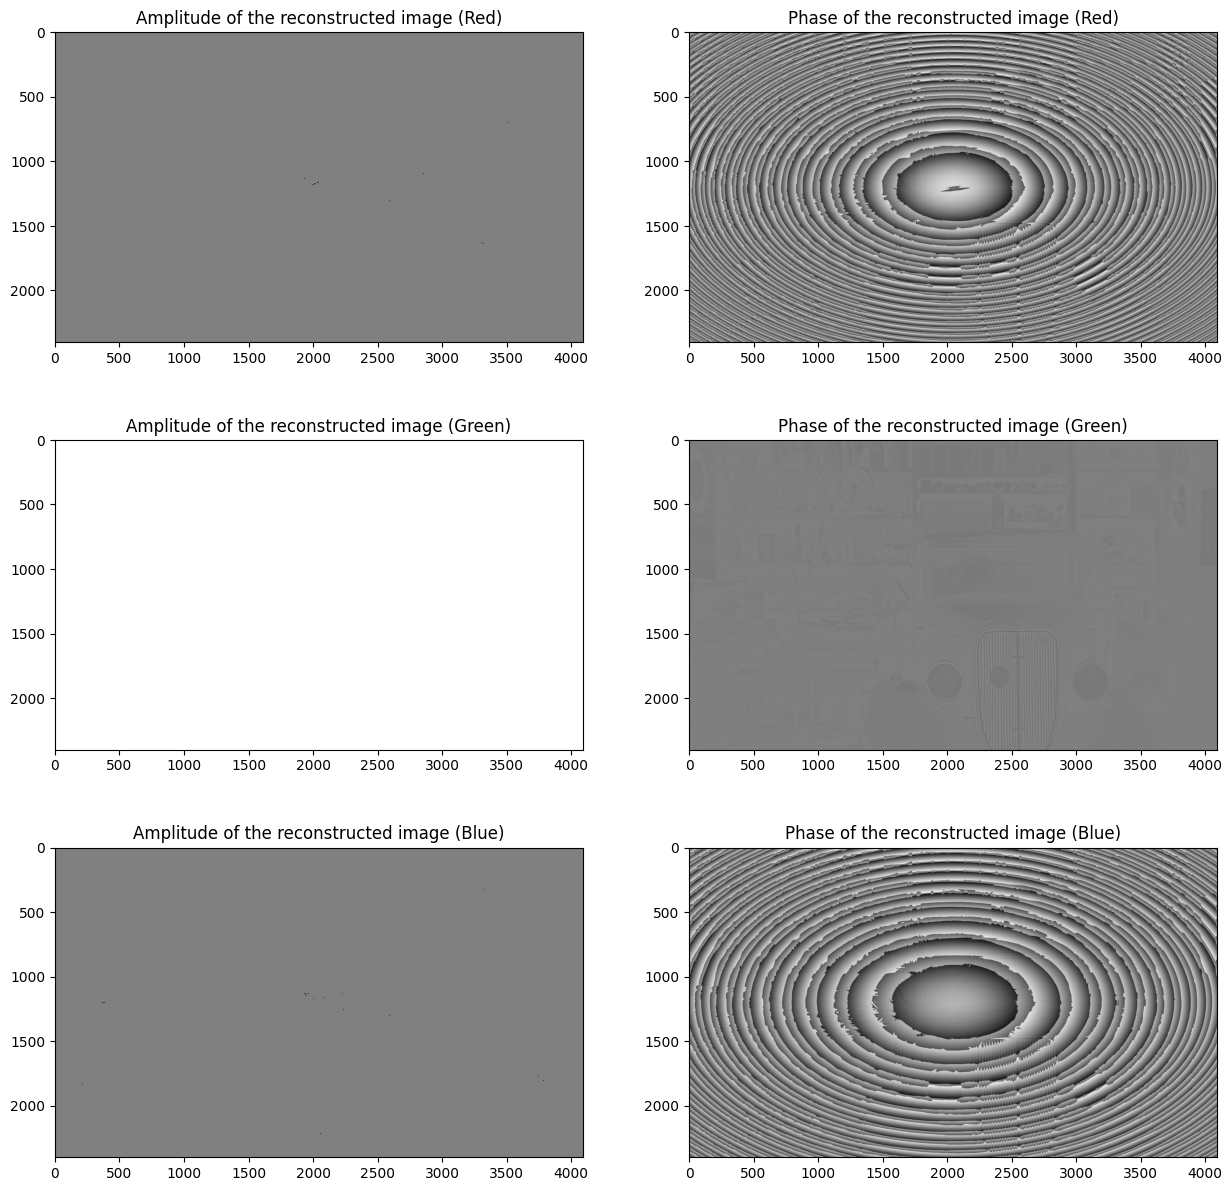

In [15]:
# plot the amplitude and phase of the reconstructed image
plt.figure(figsize=(15, 15))
plt.subplot(3, 2, 1)
plt.imshow(amplitude_z_red, cmap="gray")
plt.title("Amplitude of the reconstructed image (Red)")
plt.subplot(3, 2, 2)
plt.imshow(phase_z_red/(2*math.pi)*255, cmap="gray")
plt.title("Phase of the reconstructed image (Red)")
plt.subplot(3, 2, 3)
plt.imshow(amplitude_z_green, cmap="gray")
plt.title("Amplitude of the reconstructed image (Green)")
plt.subplot(3, 2, 4)
plt.imshow(phase_z_green/(2*math.pi)*255, cmap="gray")
plt.title("Phase of the reconstructed image (Green)")
plt.subplot(3, 2, 5)
plt.imshow(amplitude_z_blue, cmap="gray")
plt.title("Amplitude of the reconstructed image (Blue)")
plt.subplot(3, 2, 6)
plt.imshow(phase_z_blue/(2*math.pi)*255, cmap="gray")
plt.title("Phase of the reconstructed image (Blue)")
plt.show()

In [16]:
# print("The maximum value of the amplitude of the reconstructed image (Red) is {}.The minimum value is {}.".format(amplitude_z_red.max(), amplitude_z_red.min())) 
# print("The maximum value of the amplitude of the reconstructed image (Green) is {}.The minimum value is {}.".format(amplitude_z_green.max(), amplitude_z_green.min()))
# print("The maximum value of the amplitude of the reconstructed image (Blue) is {}.The minimum value is {}.".format(amplitude_z_blue.max(), amplitude_z_blue.min()))

# print("The maximum value of the phase of the reconstructed image (Red) is {}.".format(phase_z_red.max()))
# print("The maximum value of the phase of the reconstructed image (Green) is {}.".format(phase_z_green.max()))
# print("The maximum value of the phase of the reconstructed image (Blue) is {}.".format(phase_z_blue.max()))

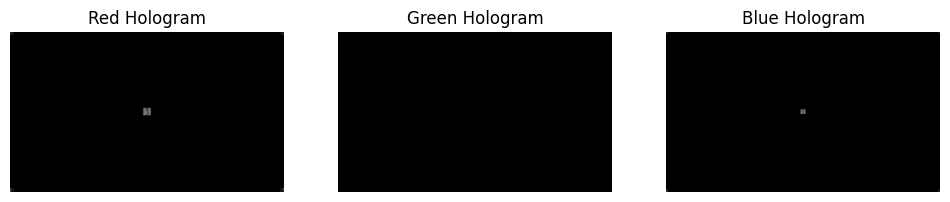

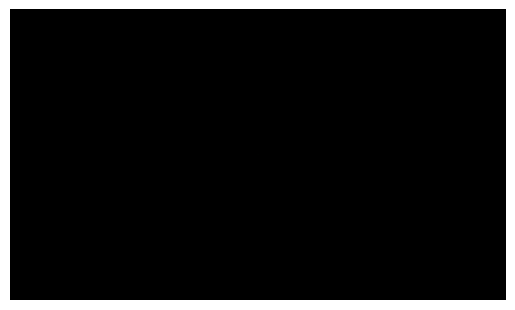

In [17]:

plt.figure(figsize=(12, 12))
plt.subplot(131)
plt.imshow(torch.abs(g_z_red)**2, cmap="grey")
plt.title("Red Hologram")
plt.axis("off")

plt.subplot(132)
plt.imshow(torch.abs(g_z_green)**2, cmap="grey")
plt.title("Green Hologram")
plt.axis("off")

plt.subplot(133)
plt.imshow(torch.abs(g_z_blue)**2, cmap="grey")
plt.title("Blue Hologram")
plt.axis("off")

plt.show()

# draw the rgb image
rgb_image = torch.stack((torch.abs(g_z_red)**2, torch.abs(g_z_green)**2, torch.abs(g_z_blue)**2), dim=2)
rgb_image = rgb_image / rgb_image.max() # normalize the image
plt.imshow(rgb_image)
plt.axis("off")
plt.show()